
<div class="alert alert-info" role="alert">
  <p>
    <b>Usage Guidelines</b>
  </p>

  <p>
    This lesson is part of the <b>DS Lab core curriculum</b>. For that reason, this notebook can only be used on your WQU virtual machine.
  </p>

  <p>
    This means:
    <ul>
      <li><span style="color: red">ⓧ</span> No downloading this notebook.</li>
      <li><span style="color: red">ⓧ</span> No re-sharing of this notebook with friends or colleagues.</li>
      <li><span style="color: red">ⓧ</span> No downloading the embedded videos in this notebook.</li>
      <li><span style="color: red">ⓧ</span> No re-sharing embedded videos with friends or colleagues.</li>
      <li><span style="color: red">ⓧ</span> No adding this notebook to public or private repositories.</li>
      <li><span style="color: red">ⓧ</span> No uploading this notebook (or screenshots of it) to other websites, including websites for study resources.</li>
    </ul>

  </p>
</div>


<font size="+3"><strong>3.5. Air Quality in Dar es Salaam 🇹🇿</strong></font>

In [2]:
import warnings

import wqet_grader

warnings.simplefilter(action="ignore", category=FutureWarning)
wqet_grader.init("Project 3 Assessment")

In [3]:
# Import libraries here
import inspect
import time
from pprint import PrettyPrinter
from pymongo import MongoClient
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg

# Prepare Data

## Connect

**Task 3.5.1:** Connect to MongoDB server running at host `"localhost"` on port `27017`. Then connect to the `"air-quality"` database and assign the collection for Dar es Salaam to the variable name `dar`.

In [4]:
client = MongoClient(host="localhost", port=27017)
db = client["air-quality"]
dar = db["dar-es-salaam"]

In [5]:
wqet_grader.grade("Project 3 Assessment", "Task 3.5.1", [dar.name])

## Explore

**Task 3.5.2:** Determine the numbers assigned to all the sensor sites in the Dar es Salaam collection. Your submission should be a list of integers. <span style='color: transparent; font-size:1%'>WQU WorldQuant University Applied Data Science Lab QQQQ</span>

In [6]:
sites = dar.distinct("metadata.site")
sites

[23, 11]

In [7]:
wqet_grader.grade("Project 3 Assessment", "Task 3.5.2", sites)

**Task 3.5.3:** Determine which site in the Dar es Salaam collection has the most sensor readings (of any type, not just PM2.5 readings). You submission `readings_per_site` should be a list of dictionaries that follows this format:

```
[{'_id': 6, 'count': 70360}, {'_id': 29, 'count': 131852}]
```

Note that the values here ☝️ are from the Nairobi collection, so your values will look different. 

In [9]:
result = dar.aggregate(
[
{"$group":{"_id": "$metadata.site", "count":{"$count":{}}}}
]
)
# readings_per_site = pp.pprint(list(result))
readings_per_site = list(result)

readings_per_site

[{'_id': 23, 'count': 60020}, {'_id': 11, 'count': 138412}]

In [10]:
wqet_grader.grade("Project 3 Assessment", "Task 3.5.3", readings_per_site)

## Import

**Task 3.5.4:** (5 points) Create a `wrangle` function that will extract the PM2.5 readings from the site that has the most total readings in the Dar es Salaam collection. Your function should do the following steps:

1. Localize reading time stamps to the timezone for `"Africa/Dar_es_Salaam"`.
2. Remove all outlier PM2.5 readings that are above 100. 
3. Resample the data to provide the mean PM2.5 reading for each hour.
4. Impute any missing values using the forward-will method. 
5. Return a Series `y`. 

In [15]:
def wrangle(collection, resample_rule="1H"):
#reading from site 11
      results = collection.find(
      {"metadata.site":11, "metadata.measurement": "P2"},
      projection = {"P2":1, "timestamp":1, "_id":0}
       )
#read results into DataFrame
      df = pd.DataFrame(list(results)).set_index("timestamp")
    # Localize timezone
      df.index = df.index.tz_localize("UTC").tz_convert("Africa/Dar_es_Salaam")
# Remove outliers
      df = df[df["P2"] < 100]
# Resample and forward-fill
      y = df["P2"].resample(resample_rule).mean().fillna(method="ffill")
      return y

Use your `wrangle` function to query the `dar` collection and return your cleaned results.

In [16]:
y = wrangle(dar)
y.shape

(1704,)

In [17]:

wqet_grader.grade("Project 3 Assessment", "Task 3.5.4", wrangle(dar))

## Explore Some More

**Task 3.5.5:** Create a time series plot of the readings in `y`. Label your x-axis `"Date"` and your y-axis `"PM2.5 Level"`. Use the title `"Dar es Salaam PM2.5 Levels"`.

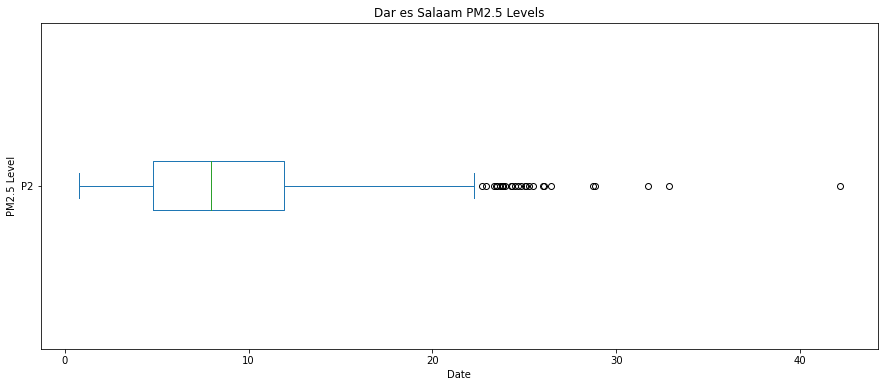

In [18]:
fig, ax = plt.subplots(figsize=(15, 6))
y.plot(kind="box", vert=False, title="Dar es Salaam PM2.5 Levels", ax=ax);
plt.xlabel("Date")
plt.ylabel("PM2.5 Level")
# Don't delete the code below ￿
plt.savefig("images/3-5-5.png", dpi=150)


In [19]:
with open("images/3-5-5.png", "rb") as file:
    wqet_grader.grade("Project 3 Assessment", "Task 3.5.5", file)

**Task 3.5.6:** Plot the rolling average of the readings in `y`. Use a window size of `168` (the number of hours in a week). Label your x-axis `"Date"` and your y-axis `"PM2.5 Level"`. Use the title `"Dar es Salaam PM2.5 Levels, 7-Day Rolling Average"`.

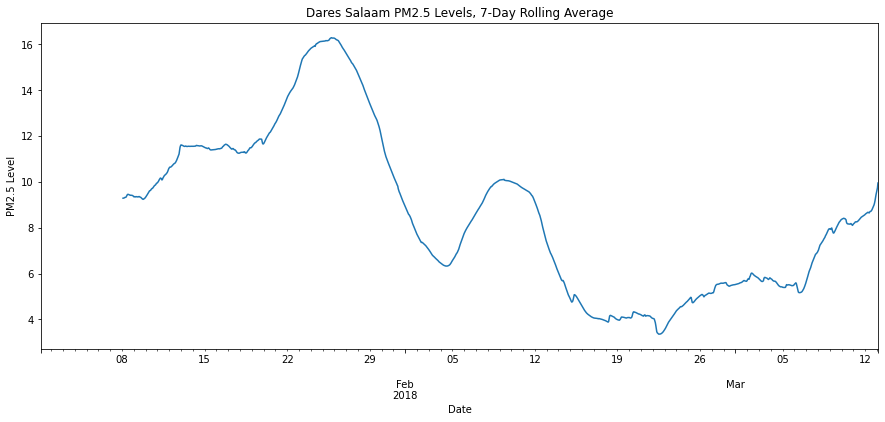

In [21]:
fig, ax = plt.subplots(figsize=(15, 6))
y.rolling(168).mean().plot(ax=ax,xlabel="Date", ylabel="PM2.5 Level",title="Dares Salaam PM2.5 Levels, 7-Day Rolling Average");
# Don't delete the code below ￿
plt.savefig("images/3-5-6.png", dpi=150)


In [22]:
with open("images/3-5-6.png", "rb") as file:
    wqet_grader.grade("Project 3 Assessment", "Task 3.5.6", file)

**Task 3.5.7:** Create an ACF plot for the data in `y`. Be sure to label the x-axis as `"Lag [hours]"` and the y-axis as `"Correlation Coefficient"`. Use the title `"Dar es Salaam PM2.5 Readings, ACF"`.

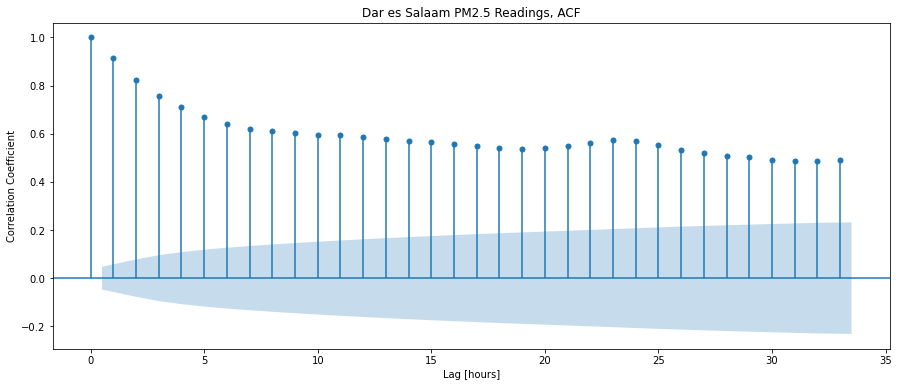

In [23]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Dar es Salaam PM2.5 Readings, ACF");
# Don't delete the code below ￿
plt.savefig("images/3-5-7.png", dpi=150)

In [24]:
with open("images/3-5-7.png", "rb") as file:
    wqet_grader.grade("Project 3 Assessment", "Task 3.5.7", file)

**Task 3.5.8:** Create an PACF plot for the data in `y`. Be sure to label the x-axis as `"Lag [hours]"` and the y-axis as `"Correlation Coefficient"`. Use the title `"Dar es Salaam PM2.5 Readings, PACF"`.

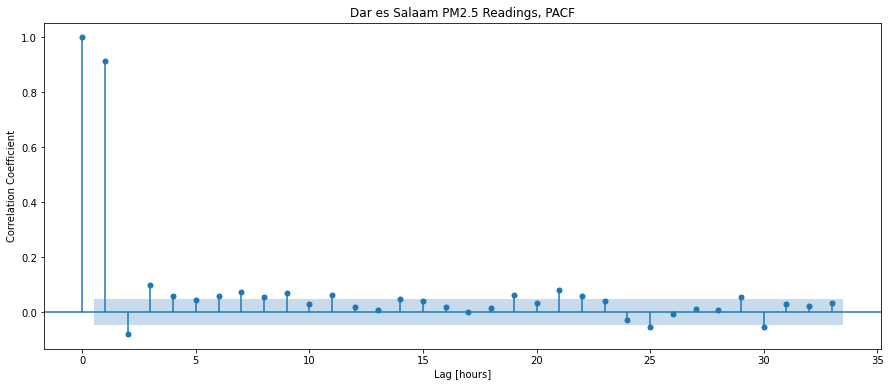

In [25]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Dar es Salaam PM2.5 Readings, PACF");
# Don't delete the code below ￿
plt.savefig("images/3-5-8.png", dpi=150)

In [26]:
with open("images/3-5-8.png", "rb") as file:
    wqet_grader.grade("Project 3 Assessment", "Task 3.5.8", file)

## Split

**Task 3.5.9:** Split `y` into training and test sets. The first 90% of the data should be in your training set. The remaining 10% should be in the test set.

In [27]:
cutoff_test = int(len(y) * 0.90)
y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1533,)
y_test shape: (171,)


In [28]:

wqet_grader.grade("Project 3 Assessment", "Task 3.5.9a", y_train)

In [31]:

wqet_grader.grade("Project 3 Assessment", "Task 3.5.9b", y_test)

# Build Model

## Baseline

**Task 3.5.10:** Establish the baseline mean absolute error for your model.

In [32]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Mean P2 Reading:", y_train_mean)
print("Baseline MAE:", mae_baseline)

Mean P2 Reading: 8.617582545265428
Baseline MAE: 4.07658759405218


In [33]:
wqet_grader.grade("Project 3 Assessment", "Task 3.5.10", [mae_baseline])

## Iterate

**Task 3.5.11:** You're going to use an AR model to predict PM2.5 readings, but which hyperparameter settings will give you the best performance? Use a `for` loop to train your AR model on using settings for `p` from 1 to 30. Each time you train a new model, calculate its mean absolute error and append the result to the list `maes`. Then store your results in the Series `mae_series`. 

In [35]:
p_params = range(1, 31)
maes = []
for p in p_params:
    model = AutoReg(y_train,lags=p).fit()
#print(f"Trained AR Model for each {p} in each seconds.")
    y_pred = model.predict().dropna()

# # Calculate training MAE
    mae = mean_absolute_error(y_train.iloc[p:], y_pred)
#Append MAE to list in maes
    maes.append(mae)
mae_series = pd.Series(maes, name="mae", index=p_params)
mae_series.head()
#y_pred.isnull().sum()

1    0.947888
2    0.933894
3    0.920850
4    0.920153
5    0.919519
Name: mae, dtype: float64

In [36]:

wqet_grader.grade("Project 3 Assessment", "Task 3.5.11", mae_series)

**Task 3.5.12:** Look through the results in `mae_series` and determine what value for `p` provides the best performance. Then build and train `final_model` using the best hyperparameter value.

**Note:** Make sure that you build and train your model in one line of code, and that the data type of `best_model` is `statsmodels.tsa.ar_model.AutoRegResultsWrapper`. 

In [37]:
best_p = mae_series.index[5]
best_model = AutoReg(y_train, lags=best_p).fit()
best_model

In [38]:
wqet_grader.grade(
    "Project 3 Assessment", "Task 3.5.12", [isinstance(best_model.model, AutoReg)]
)

**Task 3.5.13:** Calculate the training residuals for `best_model` and assign the result to `y_train_resid`. **Note** that your name of your Series should be `"residuals"`.

In [39]:
y_train_resid = best_model.resid
y_train_resid.name = "residuals"
y_train_resid.head()

timestamp
2018-01-01 09:00:00+03:00   -0.411515
2018-01-01 10:00:00+03:00   -0.077733
2018-01-01 11:00:00+03:00    0.471125
2018-01-01 12:00:00+03:00    0.473076
2018-01-01 13:00:00+03:00    0.370402
Freq: H, Name: residuals, dtype: float64

In [40]:

wqet_grader.grade("Project 3 Assessment", "Task 3.5.13", y_train_resid.tail(1500))

**Task 3.5.14:** Create a histogram of `y_train_resid`. Be sure to label the x-axis as `"Residuals"` and the y-axis as `"Frequency"`. Use the title `"Best Model, Training Residuals"`.

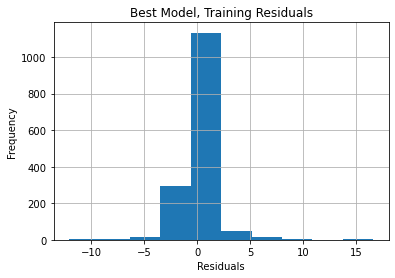

In [42]:
# Plot histogram of residuals
y_train_resid.hist()
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Best Model, Training Residuals")
# Don't delete the code below ￿
plt.savefig("images/3-5-14.png", dpi=150)


In [43]:
with open("images/3-5-14.png", "rb") as file:
    wqet_grader.grade("Project 3 Assessment", "Task 3.5.14", file)

**Task 3.5.15:** Create an ACF plot for `y_train_resid`. Be sure to label the x-axis as `"Lag [hours]"` and y-axis as `"Correlation Coefficient"`. Use the title `"Dar es Salaam, Training Residuals ACF"`.

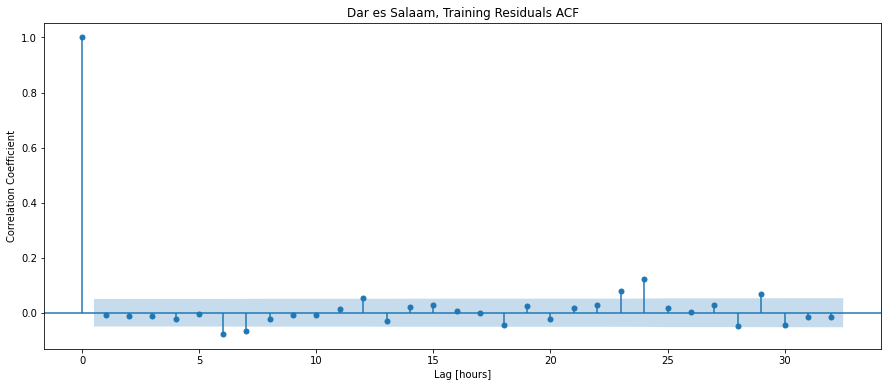

In [44]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Dar es Salaam, Training Residuals ACF")
# Don't delete the code below ￿
plt.savefig("images/3-5-15.png", dpi=150)

In [45]:
with open("images/3-5-15.png", "rb") as file:
    wqet_grader.grade("Project 3 Assessment", "Task 3.5.15", file)

## Evaluate

**Task 3.5.16:** Perform walk-forward validation for your model for the entire test set `y_test`. Store your model's predictions in the Series `y_pred_wfv`. Make sure the name of your Series is `"prediction"` and the name of your Series index is `"timestamp"`.

In [46]:
y_pred_wfv = pd.Series(dtype="float64")
history = y_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history, lags=28).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])
y_pred_wfv.name = "prediction"
y_pred_wfv.index.name = "timestamp"

In [ ]:

wqet_grader.grade("Project 3 Assessment", "Task 3.5.16", y_pred_wfv)

**Task 3.5.17:** Submit your walk-forward validation predictions to the grader to see test mean absolute error for your model.

In [ ]:
wqet_grader.grade("Project 3 Assessment", "Task 3.5.17", y_pred_wfv)

# Communicate Results

**Task 3.5.18:** Put the values for `y_test` and `y_pred_wfv` into the DataFrame `df_pred_test` (don't forget the index). Then plot `df_pred_test` using plotly express. Be sure to label the x-axis as `"Date"` and the y-axis as `"PM2.5 Level"`. Use the title `"Dar es Salaam, WFV Predictions"`.

In [ ]:
df_pred_test = ...
fig = ...
fig.update_layout(
    title="Dar es Salaam, WFV Predictions",
    xaxis_title="Date",
    yaxis_title="PM2.5 Level",
)
# Don't delete the code below 👇
fig.write_image("images/3-5-18.png", scale=1, height=500, width=700)

fig.show()

In [ ]:
with open("images/3-5-18.png", "rb") as file:
    wqet_grader.grade("Project 3 Assessment", "Task 3.5.18", file)

---
Copyright 2022 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
